In this notebook, we find the eigenvalues of the system as the time series is going on.

In [1]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import os
import math
import torch.nn as nn
from training_scripts.sMNIST.model import rnn
from training_scripts.sMNIST.dataset import MnistDataModule
import training_scripts.sMNIST.default_config as config
import matplotlib.pyplot as plt
from matplotlib import colormaps
from torch.func import jacrev, vmap
from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import Normalize
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import Callback
from pytorch_lightning.profilers import PyTorchProfiler

torch.set_float32_matmul_precision("medium")

In [ ]:
PERMUTED = False

# importing for testing
folder_name = "/vast/sr6364/dynamic-divisive-norm/tb_logs_test/rectified/sMNIST_{config.HIDDEN_SIZE}/"
model_name = "sMNIST_testing"

version = 1
seed = 73

In [3]:
def load_model(epoch_number=None, model_name=None, folder_name=None, version=0):
    checkpoint_folder = f'{folder_name}/{model_name}/version_{version}/checkpoints/'
    hparams_path = f'{folder_name}/{model_name}/version_{version}/hparams.yaml'
    checkpoint_files = os.listdir(checkpoint_folder)
    epoch_idx = [int(file.split('epoch=')[1].split('-')[0]) for file in checkpoint_files]

    if epoch_number is not None:
        # If epoch number is provided, find the index of that epoch
        max_idx = epoch_idx.index(epoch_number)
    else:
        # If epoch number is not provided, find the index of the max epoch
        max_idx = epoch_idx.index(max(epoch_idx))

    checkpoint_path = os.path.join(checkpoint_folder, checkpoint_files[max_idx])
    # print(checkpoint_path)
    model = rnn.load_from_checkpoint(checkpoint_path=checkpoint_path, map_location='cpu', hparams_file=hparams_path)
    model.eval()
    return model

In [4]:
logger = TensorBoardLogger(folder_name, name="Inference")
dm = MnistDataModule(
    data_dir=config.DATA_DIR,
    batch_size=100,
    num_workers=2,
    permuted=PERMUTED,
    seed=seed
)
# calculate training accuracy using pytorch lightning
trainer = pl.Trainer(
    logger=logger,
    max_epochs=1
)

epoch_no = None
model = load_model(epoch_no, model_name, folder_name, version)
trainer.test(model, datamodule=dm)
model.eval()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.3747999966144562
         test_f1            0.3747999966144562
        test_loss           1.8343013525009155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


rnn(
  (org): rnnCell(
    (Wzx): Identity()
    (Wr): Identity()
  )
  (fc): Linear(in_features=32, out_features=10, bias=True)
  (loss_fn): CrossEntropyLoss()
  (accuracy): MulticlassAccuracy()
  (f1_score): MulticlassF1Score()
)

In [ ]:
# plot the evolution of activations
x_example = torch.stack(model.activations["x"], dim=1).cpu()
y_example = torch.stack(model.activations["y"], dim=1).cpu()
a_example = torch.stack(model.activations["a"], dim=1).cpu()
b0_example = torch.stack(model.activations["b0"], dim=1).cpu()
b1_example = torch.stack(model.activations["b1"], dim=1).cpu()
print(y_example.shape)
print(x_example.shape)

torch.Size([100, 785, 32])
torch.Size([100, 784, 1])


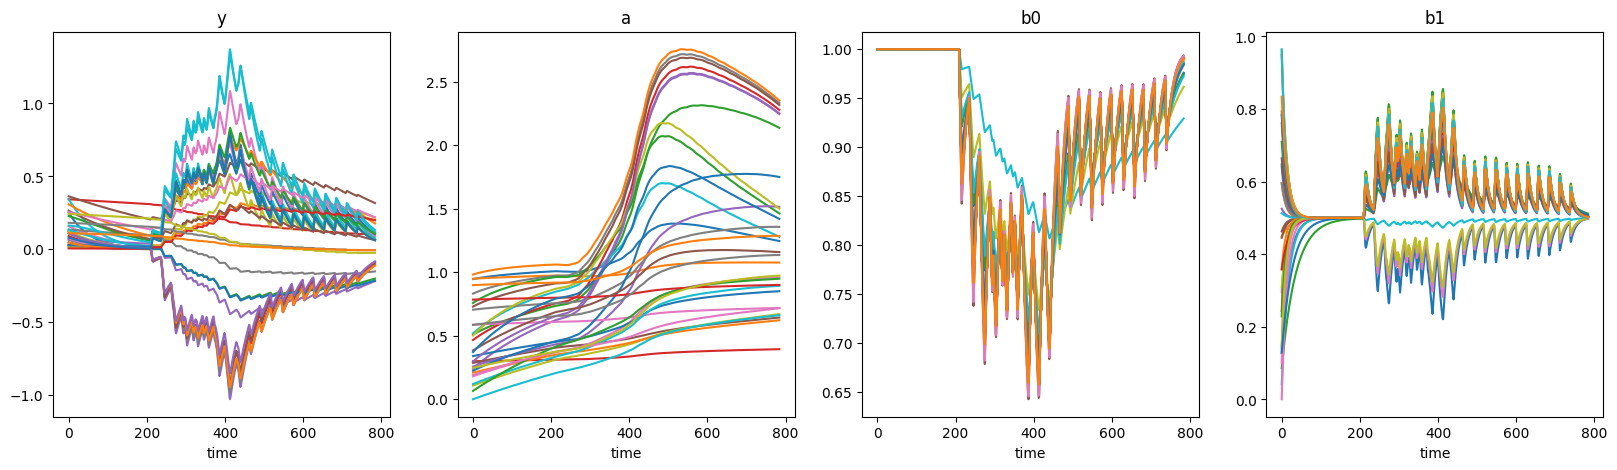

In [6]:
# plot y_example[0, :, :] and a_example[0, :, :] side by side
fig, axs = plt.subplots(1, 4)
# increase the figsze
batch_idx = 9
fig.set_size_inches(20, 5)
axs[0].plot(y_example[batch_idx, :, :])
axs[0].set_title('y')
axs[0].set_xlabel('time')

axs[1].plot(a_example[batch_idx, :, :])
axs[1].set_title('a')
axs[1].set_xlabel('time')

axs[2].plot(b0_example[batch_idx, :, :])
axs[2].set_title('b0')
axs[2].set_xlabel('time')

axs[3].plot(b1_example[batch_idx, :, :])
axs[3].set_title('b1')
axs[3].set_xlabel('time')
plt.show()

In [7]:
dt = 0.01
time_steps = 784

organics_model = model.org
tauY = dt / organics_model.dt_tauy()
tauA = dt / organics_model.dt_taua()
tauB0 = dt / organics_model.dt_taub0()
tauB1 = dt / organics_model.dt_taub1()

In [8]:
# size of the ORGaNICs circuit
N = 32

# defining parameters from the model
Wzx = organics_model.Wzx()
Wyy = organics_model.Wr()
Way = organics_model.Way()
sigma = organics_model.sigma

In [9]:
num_time_steps = 784
time_nums = list(range(0, num_time_steps))
num_examples = 5
max_real_eigenvals_training = torch.zeros(len(time_nums), num_examples)


for time_idx in time_nums:
    x_t = x_example[:, time_idx, :]
    # b1_t = b1_example[:, time_idx, :]
    # b0_t = b0_example[:, time_idx, :]

    max_real_eigenvals = torch.zeros((num_examples), dtype=torch.float32)

    def _dynamical_fun(vect, x):
        """
        This function defines the dynamics of the ring ORGaNICs model.
        :param x: The state of the network.
        :return: The derivative of the network at the current time-step.
        """
        y = vect[0:N]
        a = vect[N:2*N]
        b0 = vect[2*N:3*N]
        b1 = vect[3*N:4*N]
        dydt = (1 / tauY) * (-y + b1 * (Wzx @ x)
                + (1 - torch.sqrt(torch.relu(a))) * (Wyy @ F.relu(y)))
        dadt = (1 / tauA) * (-a + (sigma * b0) ** 2 + Way @ (F.relu(a) * F.relu(y) ** 2))
        # db0dt = (1 / tauB0) * (-b0 + organics_model.B0(x, y, a))
        db0dt = (1 / tauB0) * (-b0 + organics_model.B0(Wzx @ x))
        db1dt = (1 / tauB1) * (-b1 + organics_model.B1(x, y, a))
        return torch.cat((dydt, dadt, db0dt, db1dt))

    for idx in range(num_examples):
        x_new = x_t[idx, :]
        output_y = y_example[idx, time_idx, :]
        output_a = a_example[idx, time_idx, :]
        output_b0 = b0_example[idx, time_idx, :]
        output_b1 = b1_example[idx, time_idx, :]
        vect = torch.cat((output_y, output_a, output_b0, output_b1), dim=0)
        jac = jacrev(_dynamical_fun)(vect, x_new)
        max_real_eigenvals[idx] = torch.max(torch.real(torch.linalg.eigvals(jac)))
    
    max_real_eigenvals_training[time_idx, :] = max_real_eigenvals.detach().clone()


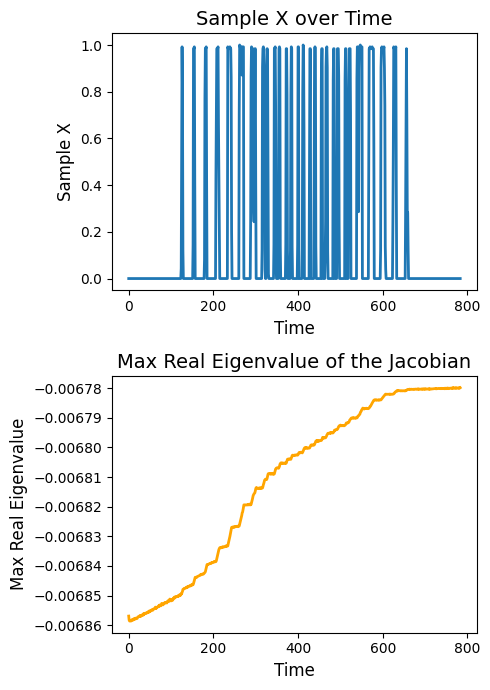

In [10]:
# plot max_real_eigenvals_training as a function of time
idx_plot = 3
sample_x = x_example[idx_plot, :, 0]

# Create a figure with two subplots side by side
fig, ax = plt.subplots(2, 1, figsize=(5, 7))

# Plot sample_x on the left subplot
ax[0].plot(time_nums, sample_x, linewidth=2)
ax[0].set_xlabel('Time', fontsize=12)
ax[0].set_ylabel('Sample X', fontsize=12)
ax[0].set_title('Sample X over Time', fontsize=14)
# ax[0].grid(True)

# Plot max_real_eigenvals_training on the right subplot
ax[1].plot(time_nums, max_real_eigenvals_training[:, idx_plot], color='orange', linewidth=2)
ax[1].set_xlabel('Time', fontsize=12)
ax[1].set_ylabel('Max Real Eigenvalue', fontsize=12)
ax[1].set_title('Max Real Eigenvalue of the Jacobian', fontsize=14)
# ax[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

Jacobian evaluated at the fixed point at each time-step.

In [36]:
ct = 0

In [38]:
num_time_steps = 784
time_nums = list(range(0, num_time_steps))
num_examples = 5
max_real_eigenvals_training = torch.zeros(len(time_nums), num_examples)


for time_idx in time_nums:
    x_t = x_example[:, time_idx, :]
    # b1_t = b1_example[:, time_idx, :]
    # b0_t = b0_example[:, time_idx, :]

    max_real_eigenvals = torch.zeros((num_examples), dtype=torch.float32)

    def _dynamical_fun(vect, x, b0, b1):
        """
        This function defines the dynamics of the ring ORGaNICs model.
        :param x: The state of the network.
        :return: The derivative of the network at the current time-step.
        """
        y = vect[0:N]
        a = vect[N:2*N]
        dydt = (1 / tauY.detach().clone()) * (-y + b1 * (Wzx.detach().clone() @ x)
                + (1 - torch.sqrt(torch.relu(a))) * (Wyy.detach().clone() @ F.relu(y)))
        dadt = (1 / tauA.detach().clone()) * (-a + (sigma.detach().clone() * b0) ** 2 + Way.detach().clone() @ (F.relu(a) * F.relu(y) ** 2))
        return torch.cat((dydt, dadt))

    for idx in range(num_examples):
        x_new = x_t[idx, :]

        b0 = organics_model.B0(Wzx @ x_new).detach().clone()
        b1 = organics_model.B1(x_new, 0, 0).detach().clone()

        # find the fixed point
        a_ss = (sigma * b0) ** 2 + Way @ (b1 * torch.relu(Wzx @ x_new)) ** 2
        y_ss = b1 * torch.relu(Wzx @ x_new) / torch.sqrt(a_ss)
        vect = torch.cat((y_ss, a_ss), dim=0).detach().clone()

        if x_new > 0 and ct == 0:
            ct = 1
            print(vect)
        
        jac = jacrev(_dynamical_fun, argnums=0)(vect, x_new, b0, b1)
        max_real_eigenvals[idx] = torch.min(torch.real(torch.linalg.eigvals(jac)))
    
    max_real_eigenvals_training[time_idx, :] = max_real_eigenvals.detach().clone()

In [39]:
vect

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

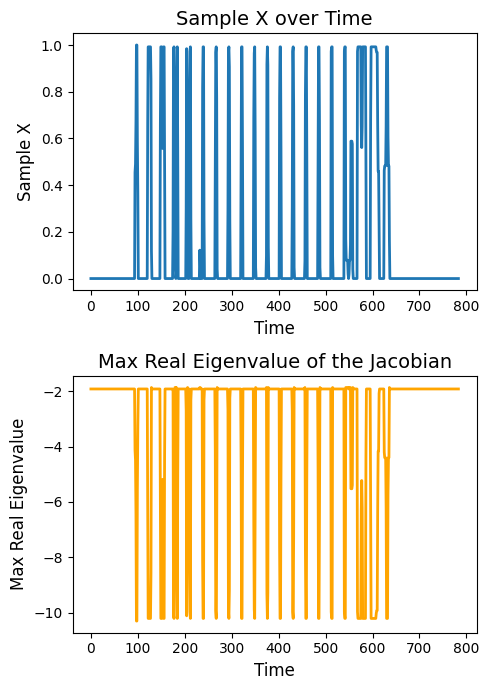

In [40]:
# plot max_real_eigenvals_training as a function of time
idx_plot = 1
sample_x = x_example[idx_plot, :, 0]

# Create a figure with two subplots side by side
fig, ax = plt.subplots(2, 1, figsize=(5, 7))

# Plot sample_x on the left subplot
ax[0].plot(time_nums, sample_x, linewidth=2)
ax[0].set_xlabel('Time', fontsize=12)
ax[0].set_ylabel('Sample X', fontsize=12)
ax[0].set_title('Sample X over Time', fontsize=14)
# ax[0].grid(True)

# Plot max_real_eigenvals_training on the right subplot
ax[1].plot(time_nums, max_real_eigenvals_training[:, idx_plot], color='orange', linewidth=2)
ax[1].set_xlabel('Time', fontsize=12)
ax[1].set_ylabel('Max Real Eigenvalue', fontsize=12)
ax[1].set_title('Max Real Eigenvalue of the Jacobian', fontsize=14)
# ax[1].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()